# Transfer learning for designing the lattice inspsired from the work of gongora et.al

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
import copy

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,Kernel,Hyperparameter,ConstantKernel,Matern, RationalQuadratic
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import LeaveOneOut
import time
import torch.nn as nn
import torch
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil


## Samples from Quasi-static and the corresponding Id

In [7]:
samples=np.load('sampled_quasi_series.npy')
sample_id=np.load('qs_num_list.npy')

## Loading full data corresponding to quasi-static and impact testing

In [8]:
import pandas as pd
impact_testing=pd.read_csv('Impact Testing_Dataset_Table.csv')
Quasi_static_testing=pd.read_csv('Lattice Data V3.0_Dataset_Table.csv')

## choosing the filtered_quasi_data that has corresponding F-D curve from the qs_num_list.npy

In [9]:

row_index_filtered = []
for ii in sample_id:
    mask = Quasi_static_testing['WADL ID'] == ii
    if mask.any():
        row_number = Quasi_static_testing[mask].index[0]
        row_index_filtered.append(row_number)
Quasi_static_testingg = Quasi_static_testing.iloc[row_index_filtered, :]

In [10]:
Quasi_static_testing_Octet=Quasi_static_testingg[Quasi_static_testing['Unit Cell Type']=='Octet']
wadl_id=Quasi_static_testing_Octet['WADL ID'].tolist()

/tmp/ipykernel_1699/628023494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Quasi_static_testing_Octet=Quasi_static_testingg[Quasi_static_testing['Unit Cell Type']=='Octet']


In [11]:
## Finding the row number for sample_id corresponding to the Octet design

row_index_sampleid = []
for ii in wadl_id:
    mask = sample_id == ii
    if mask.any():
        row_number = np.where(mask)[0][0]
        row_index_sampleid.append(row_number)
sample_id_final = sample_id[row_index_sampleid]
samples_final=samples[row_index_sampleid]
print(sample_id_final.shape)


(671,)


## Filter out rows from quasi-static where the value in the imapact column is not None

In [12]:
filtered_data_quasi = Quasi_static_testing_Octet[Quasi_static_testing_Octet['IT ID'].notna()& (Quasi_static_testing_Octet['IT ID'] != '') & (Quasi_static_testing_Octet['Unit Cell Type']=='Octet')]


## Filter out rows from impact where the value in the Quasi-static column is not None and acclerations are not zero

In [13]:
impact_testing.columns = impact_testing.columns.str.replace("g's", 'g', regex=False)



In [14]:
impact_testing['WADL ID'] = impact_testing['WADL ID'].apply(lambda x: None if x == 'None' else x)
filtered_data_impact_1 = impact_testing[impact_testing['WADL ID'].notna()& (impact_testing['WADL ID'] != '') & impact_testing['Acceleration 1 (g)']!=0]   

filtered_data_impact_2 = impact_testing[impact_testing['WADL ID'].notna()& (impact_testing['WADL ID'] != '') & impact_testing['Acceleration 2 (g)']!=0]          





  

In [15]:

filtered_data_quasi=filtered_data_quasi.sort_values(by='WADL ID')

mapping={'Octet':1,'Reinforced Octet':2,'Octahedral':3,'Reinforced Octahedral':4,'Body-Centered Cubic':5}

filtered_data_quasi['Unit Cell Type']=filtered_data_quasi['Unit Cell Type'].replace(mapping)



/tmp/ipykernel_1699/665128768.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_data_quasi['Unit Cell Type']=filtered_data_quasi['Unit Cell Type'].replace(mapping)


## Using GRU to reduce the Dimension of the F-D Curve from 148 to 2

In [16]:
global device, print_freq
print_freq = 50
device = torch.device('cuda')



In [17]:
# GRU auto encoder
class GRU_encoder(torch.nn.Module):

    def __init__(self,reduced_size=2,num_layers=3,hidden_size=50):
        super().__init__()
        self.leakrelu = torch.nn.LeakyReLU()
        self.gru = torch.nn.GRU(3, hidden_size, num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, reduced_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x):
        a0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, a = self.gru(x, a0)

        out = self.leakrelu(out)
        out = self.fc1(out)

        return out,x

class GRU_decoder(torch.nn.Module):

    def __init__(self,reduced_size=2,num_layers=3,hidden_size=50):
        super().__init__()

        self.leakrelu = torch.nn.LeakyReLU()
        self.gru = torch.nn.GRU(reduced_size+1, hidden_size, num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, 3)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.reduced_size=reduced_size

    def forward(self, a0_init,x):

        # a0_init = self.fc1(a00)
        a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)
        aug_a = a0_init.repeat(1, samples.shape[1]).reshape(a0_init.shape[0],
                                               samples.shape[1], a0_init.shape[1])

        #print(aug_a.shape)
        #print(samples[:,:,0].shape)
        aug_a1=torch.cat((aug_a,(x[:,:,0]).unsqueeze(2).to(device).float()),dim=2)
        # inp = torch.cat(aug_a, axis=2)
        out, a = self.gru(aug_a1, a0)
        out = self.leakrelu(out)
        out = self.fc1(out)
        return out

class GRU_encoder_decoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = GRU_encoder()
        self.decoder = GRU_decoder()

    def forward(self, inp_encoder):

        y_code,x = self.encoder(inp_encoder)
        #print(y_code[:, y_code.shape[1] - 1].shape)
        y_recovered = self.decoder(y_code[:, y_code.shape[1] - 1],x)
        return y_recovered,y_code[:, y_code.shape[1] - 1]

In [18]:
encoder_decoder = GRU_encoder_decoder().to(device)

test_sample=torch.from_numpy(samples_final)
#test_sample = torch.normal(0, 1, size=(6, 150, 3))
y,y_encoded = encoder_decoder(test_sample.to(device).float())
print(y.shape)
print(y_encoded.shape)

torch.Size([671, 148, 3])
torch.Size([671, 2])


In [19]:
print_freq = 400

class MinMax_Scaler(object):

    def __init__(self, data, keep_data=False):
        self.min = np.min(data, axis=(0, 1), keepdims=True)
        self.max = np.max(data, axis=(0, 1), keepdims=True)

        if keep_data is True:
            self.data = self.transform(data, tensor=False)
        else:
            self.data = []

    def transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = (data - self.min) / (self.max - self.min)
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.div(torch.sub(data[:, :, c], min_tensor[0, 0, c]), torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c]))
        return data

    def inv_transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = data * (self.max - self.min) + self.min
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.add(torch.mul(data[:, :, c], torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c])), min_tensor[0, 0, c])
        return data

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, strain, stress):
        self.strain = strain
        self.stress = stress

    def __len__(self):
        return self.strain.shape[0]

    def __getitem__(self, index):
        return self.strain[index], self.stress[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def customized_loss(output, target):

    mse = torch.nn.MSELoss()

    output1 = output[:, :, 0:3]
    output2 = output[:, :, 3:6]

    target1 = target[:, :, 0:3]
    target2 = target[:, :, 3:6]

    return 0.5 * torch.maximum(mse(output1, target1), mse(output2, target2))

def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,_ = model(input)
        loss = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 500 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,_ = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 500 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best(OCTET)_tr.pth.tar')


def train_GRU(model, net_info, train_loader, test_loader,net_params):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(net_params['hidden_size'],net_params['num_layers']))
    plt.yscale('log')
    plt.legend()
    plt.show()

    return model
#@title main_program()
def main_program(strain, stress,net_params,model, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    strain_train = strain[0:num_sample, :, :]
    stress_train = stress[0:num_sample, :, :]
    training_set = MyDataset(strain_train, stress_train)

    strain_test = strain[num_sample:strain.shape[0], :, :]
    stress_test = stress[num_sample:strain.shape[0], :, :]
    val_set = MyDataset(strain_test, stress_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_GRU(model, trainer_info, train_loader, test_loader,net_params)
    torch.save(model.state_dict(), model_name)

    return model




In [20]:
net_params = {'input_size': 3,
              'hidden_size': 50,
              'num_layers': 2,
              'output_size': 3}

trainer_info = {'epochs': 3600,
                'train_size': 535,
                'train_batch': 64,
                'test_batch': 256,
                'lr0': 1.0e-2,
                'lr_decay': 0.7}

note = 'ann'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(net_params['num_layers']) + 'layer_' + str(net_params['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note


In [21]:
samples_final=samples_final.astype(np.float32)
test_s=MinMax_Scaler(samples_final)
test_samples=test_s.transform(samples_final)
test_samples=test_samples.astype(np.float32)
print(test_samples.shape)

(671, 148, 3)


In [ ]:
model=GRU_encoder_decoder().to(device).float()
print(test_samples.shape)
import time
start_time = time.time()

model = main_program(test_samples,test_samples, net_params,model, trainer_info, model_name)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

In [23]:
best_model_params = torch.load('model_best(OCTET).pth.tar', map_location=device)['state_dict']

In [24]:
model = GRU_encoder_decoder().to(device)
model.load_state_dict(best_model_params)

<All keys matched successfully>

In [25]:
print(test_samples.shape)


(671, 148, 3)


In [26]:
reconstruction,reduced_force_GRU=model(torch.from_numpy(test_samples).to(device).float())


In [27]:
reduced_force_GRU.shape

torch.Size([671, 2])

In [41]:
Force=(samples_final[:,:,1])
meanF=np.mean(Force,axis=0,keepdims=True)
Sigma=np.cov(Force.T)
eig,Phi=np.linalg.eig(Sigma)
Force_reduced=np.matmul(Phi[:,0:11].T,Force.T-meanF.T)
Force_reconstructed=np.matmul(Phi[:,0:11],Force_reduced) +meanF.T 

In [42]:
print(Force_reduced.shape)

(11, 671)


In [47]:
print(samples_final[:,:,1].shape)
Force_recon=Force_reconstructed.T
print(Force_recon.shape)

(671, 148)
(671, 148)


In [55]:
print(samples_final[550,:,1])

[202.     202.1141 202.2484 202.3813 202.5143 202.6483 202.7814 202.9147
 203.0478 203.1815 203.315  203.4473 203.5815 203.7151 203.8475 203.9818
 204.1145 204.2478 204.3815 204.5147 204.6482 204.7808 204.9149 205.0483
 205.1806 205.315  205.4482 205.581  205.7149 205.848  205.9813 206.1146
 206.2481 206.3817 206.5139 206.6483 206.7814 206.914  207.0483 207.1815
 207.3145 207.4481 207.5814 207.7148 207.8475 207.9815 208.1151 208.2474
 208.3818 208.5147 208.6476 208.7817 208.9147 209.048  209.1811 209.3147
 209.4482 209.5807 209.715  209.8484 209.9808 210.1151 210.2479 210.3812
 210.5147 210.6481 210.7815 210.9142 211.0482 211.1816 211.3139 211.4483
 211.5815 211.7144 211.8483 211.9812 212.1147 212.2478 212.3814 212.515
 212.6473 212.7816 212.9149 213.0474 213.1817 213.3149 213.4478 213.5813
 213.7147 213.8481 213.981  214.1148 214.2484 214.3807 214.5151 214.6479
 214.7809 214.915  215.0479 215.1814 215.3143 215.4481 215.5815 215.714
 215.8482 215.9816 216.1142 216.2484 216.3813 216.514

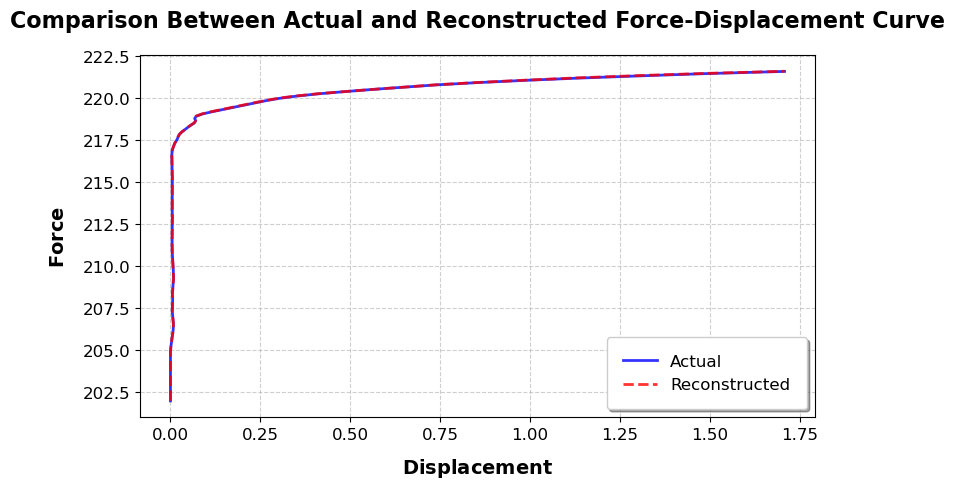

In [59]:
# Example data (replace with your actual data)
actual=test_s.inv_transform(test_samples)[650,:,:]
reconstructed=test_s.inv_transform(reconstruction.cpu().detach().numpy())[650,:,:]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Larger size for better visibility

# Plot actual and reconstructed data
ax.plot(actual[:, 2], actual[:, 1], label='Actual', color='blue', linewidth=2, linestyle='-', alpha=0.8)
ax.plot(actual[:, 2], reconstructed[:, 1], label='Reconstructed', color='red', linewidth=2, linestyle='--', alpha=0.8)
#ax.plot(actual[:, 2], Force_reconstructed[:,2], label='Reconstruction from PCA', color='orange', linewidth=2, linestyle='--', alpha=0.8)

# Add labels with LaTeX formatting
ax.set_xlabel(r'$\mathbf{Displacement}$', fontsize=14, labelpad=10, fontweight='bold')
ax.set_ylabel(r'$\mathbf{Force}$', fontsize=14, labelpad=10, fontweight='bold')

# Add a title
ax.set_title('Comparison Between Actual and Reconstructed Force-Displacement Curve',
             fontsize=16, fontweight='bold', pad=20)

# Customize legend
ax.legend(fontsize=12, loc='lower right', frameon=True, fancybox=True, shadow=True, borderpad=1)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
import matplotlib.pyplot as plt



## Choosing WADL ID(quasi-static data) that is used by Impact test.

In [117]:
collumns=Quasi_static_testing_Octet['IT ID']
WADL_id= Quasi_static_testing_Octet['WADL ID'].tolist()
rows=[]
WADL_ID=[]
jj=0
for i in collumns:
    if (pd.notna(i) and i !=''):
        WADL_ID.append(WADL_id[jj])
    jj=jj+1

## Filtering out WADL ID that isn't present in sample_id.npy and getting the row index of that WADL id

In [118]:
sample_id_set = set(sample_id_final)  # Convert to set for faster lookups

final_row_index=[]
final_WADL_id=[]
ii=0
for i in sample_id_final:
    if i in WADL_ID:
        final_row_index.append(ii)
        final_WADL_id.append(i)
    ii=ii+1

print((final_row_index))
print((final_WADL_id))

[1, 29, 55, 56, 57, 66, 68, 71, 75, 89, 103, 109, 149, 154, 161, 182, 191, 198, 208, 248, 251, 265, 294, 312, 317, 324, 328, 336, 346, 350, 367, 400, 411, 423, 433, 439, 440, 455, 464, 491, 506, 510, 513, 515, 517, 519, 551, 581, 584, 615, 618, 625, 630, 633, 646, 663]
[2, 30, 56, 57, 58, 67, 69, 72, 76, 90, 104, 110, 151, 156, 163, 186, 195, 202, 212, 252, 256, 270, 299, 317, 322, 329, 333, 341, 352, 356, 373, 407, 418, 430, 440, 446, 447, 463, 472, 499, 514, 518, 521, 523, 525, 527, 559, 589, 592, 623, 626, 633, 638, 641, 654, 671]


In [119]:
reduced_force=reduced_force_GRU[final_row_index].detach().cpu().numpy()

In [120]:
## Creating final data for training and prediction
#'Mass (g)'
#'Unit Cell Type'
#'x_bend (mm)'
#'x _stretch (mm)'
#'x_joint (mm)'
#,'Energy Absorbed (J)'
# ass (g)
quasi_data=filtered_data_quasi.loc[:,['WADL ID','x_bend (mm)','x _stretch (mm)','x_joint (mm)']].values

In [121]:
print(quasi_data.shape)
print(reduced_force.shape)

(56, 4)
(56, 2)


## Concactenate features from quasi_data  and reduced F-D curve

In [122]:
combined_quasi_data=np.concatenate([quasi_data,reduced_force],axis=1)

## Extracting the accleration from impact data correspong to the final-WADL id

In [123]:
collumns = ['WADL ID', 'Acceleration 1 (g)', 'Acceleration 2 (g)']
impact_data_filtered_1 = filtered_data_impact_1[filtered_data_impact_1['WADL ID'].isin(final_WADL_id)]
impact_data_filtered_1 = impact_data_filtered_1.sort_values(by='WADL ID')
impact1 = impact_data_filtered_1.loc[:, collumns].values


impact_data_filtered_2 = filtered_data_impact_2[filtered_data_impact_2['WADL ID'].isin(final_WADL_id)]
impact_data_filtered_2 = impact_data_filtered_2.sort_values(by='WADL ID')
impact2 = impact_data_filtered_2.loc[:, collumns].values



In [124]:
print(combined_quasi_data[:,0])

[  2.  30.  56.  57.  58.  67.  69.  72.  76.  90. 104. 110. 151. 156.
 163. 186. 195. 202. 212. 252. 256. 270. 299. 317. 322. 329. 333. 341.
 352. 356. 373. 407. 418. 430. 440. 446. 447. 463. 472. 499. 514. 518.
 521. 523. 525. 527. 559. 589. 592. 623. 626. 633. 638. 641. 654. 671.]


## Pick the data from combined_quasi_data and match it with impact acceleration based on WADL_ID

In [125]:
'''
#final_combined_data=np.zeros([impact.shape[0],combined_quasi_data.shape[1]-1])
#wadl_index=impact[:,0].astype(int)

# Just to train with one of the instances of impact testing rathar than different impact samples with same features
final_combined_data=np.zeros([combined_quasi_data.shape[0],combined_quasi_data.shape[1]-1])
wadl_index=combined_quasi_data[:,0].astype(int)
row_number_first_instance=[]
ii=0
for i in (wadl_index):
    row_number = np.where(combined_quasi_data[:, 0] == i)[0] # remove [0] if you want all the impact data with same features(with different output) to be considered
    test = np.where(combined_quasi_data[:, 0] == i)
    final_combined_data[ii,:]=combined_quasi_data[row_number,1:]
    ii=ii+1 
'''

'\n#final_combined_data=np.zeros([impact.shape[0],combined_quasi_data.shape[1]-1])\n#wadl_index=impact[:,0].astype(int)\n\n# Just to train with one of the instances of impact testing rathar than different impact samples with same features\nfinal_combined_data=np.zeros([combined_quasi_data.shape[0],combined_quasi_data.shape[1]-1])\nwadl_index=combined_quasi_data[:,0].astype(int)\nrow_number_first_instance=[]\nii=0\nfor i in (wadl_index):\n    row_number = np.where(combined_quasi_data[:, 0] == i)[0] # remove [0] if you want all the impact data with same features(with different output) to be considered\n    test = np.where(combined_quasi_data[:, 0] == i)\n    final_combined_data[ii,:]=combined_quasi_data[row_number,1:]\n    ii=ii+1 \n'

In [126]:

final_combined_data_1=np.zeros([impact1.shape[0],combined_quasi_data.shape[1]-1])
wadl_index1=impact1[:,0].astype(int)


row_number_first_instance_1=[]
ii=0
for i in (wadl_index1):
    row_number = np.where(combined_quasi_data[:, 0] == i)[0] # remove [0] if you want all the impact data with same features(with different output) to be considered
    final_combined_data_1[ii,:]=combined_quasi_data[row_number,1:]
    ii=ii+1


final_combined_data_2=np.zeros([impact2.shape[0],combined_quasi_data.shape[1]-1])
wadl_index2=impact2[:,0].astype(int)


row_number_first_instance_2=[]
ii=0
for i in (wadl_index2):
    row_number = np.where(combined_quasi_data[:, 0] == i)[0] # remove [0] if you want all the impact data with same features(with different output) to be considered
    final_combined_data_2[ii,:]=combined_quasi_data[row_number,1:]
    ii=ii+1

print(final_combined_data_1.shape)
print(final_combined_data_2.shape)


(118, 5)
(116, 5)


In [127]:
impact1.shape
print(impact1[:,0])

[  2.   2.   2.   2.   2.  30.  30.  56.  56.  56.  56.  57.  57.  57.
  58.  58.  58.  67.  67.  67.  69.  69.  69.  72.  76.  90.  90.  90.
 104. 104. 104. 110. 151. 151. 151. 156. 156. 156. 163. 186. 195. 202.
 212. 252. 256. 270. 270. 270. 299. 317. 317. 317. 322. 329. 333. 341.
 352. 356. 356. 356. 373. 407. 407. 407. 418. 430. 430. 430. 440. 440.
 440. 446. 446. 446. 447. 463. 472. 499. 499. 499. 514. 514. 514. 514.
 514. 514. 514. 518. 521. 521. 521. 521. 523. 525. 525. 525. 527. 559.
 589. 592. 623. 623. 623. 626. 633. 638. 638. 638. 641. 641. 641. 641.
 654. 654. 654. 671. 671. 671.]


In [128]:
final_combined_data_dummy=np.zeros([impact1.shape[0],combined_quasi_data.shape[1]])
wadl_index_dummy=impact1[:,0].astype(int)
ii=0


for i in (wadl_index_dummy):
    row_number_dummy = np.where(combined_quasi_data[:, 0] == i)[0][0]
    final_combined_data_dummy[ii,:] = combined_quasi_data[row_number_dummy,:]
    ii=ii+1  
row_number_first_instance_1=[]


for i in (combined_quasi_data[:,0]):
    ro=np.where(final_combined_data_dummy[:, 0] == i)[0]
    if ro.size > 0:
        row_number_first_instance_1.append(ro[0])
    else:
        print(f"No matching row found for index {i}")
        continue  # Skip this iteration or handle it as needed

print(row_number_first_instance_1)


final_combined_data_dummy=np.zeros([impact2.shape[0],combined_quasi_data.shape[1]])
wadl_index_dummy=impact2[:,0].astype(int)
ii=0

for i in (wadl_index_dummy):
    row_number_dummy = np.where(combined_quasi_data[:, 0] == i)[0][0]
    final_combined_data_dummy[ii,:] = combined_quasi_data[row_number_dummy,:]
    ii=ii+1  
row_number_first_instance_2=[]



for i in (combined_quasi_data[:,0]):
    ro=np.where(final_combined_data_dummy[:, 0] == i)[0]
    if ro.size > 0:
        row_number_first_instance_2.append(ro[0])
    else:
        print(f"No matching row found for index {i}")
        continue  # Skip this iteration or handle it as needed
       
print(row_number_first_instance_2)




[0, 5, 7, 11, 14, 17, 20, 23, 24, 25, 28, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 64, 65, 68, 71, 74, 75, 76, 77, 80, 87, 88, 92, 93, 96, 97, 98, 99, 100, 103, 104, 105, 108, 112, 115]
No matching row found for index 76.0
[0, 4, 6, 10, 13, 16, 19, 22, 23, 26, 29, 30, 33, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 50, 51, 52, 53, 54, 55, 58, 59, 62, 63, 66, 69, 72, 73, 74, 75, 78, 85, 86, 90, 91, 94, 95, 96, 97, 98, 101, 102, 103, 106, 110, 113]


## Creating Final data matrix

In [129]:
Xdata1=final_combined_data_1[row_number_first_instance_1]## Filter out data containing zero accerleration

Xdata2=final_combined_data_2[row_number_first_instance_2]

Y1=impact1[:,1:2][row_number_first_instance_1] # acceleration1

Y2=impact2[:,2:3][row_number_first_instance_2] # acceleration2


In [284]:
Xtrain, Xtest, Ytrain, Ytest=train_test_split(Xdata2[:,:5],Y2,train_size=0.8)#,random_state=1)
#kernel= WhiteKernel()+DotProduct() + RBF(length_scale=0.05, length_scale_bounds=(1e-5, 100000.0))

#kernel=RBF(length_scale=0.01, length_scale_bounds=(1e-3, 10000000.0))


X=MinMaxScaler()
Y=StandardScaler()

In [285]:
alls=0
if alls==1:
    Xtrain=Xdata1.copy()
    Ytrain=Y1.copy()


In [286]:
print(Xdata1.shape)
print(Y1.shape)


print(Xdata2.shape)
print(Y2.shape)

(56, 5)
(56, 1)
(55, 5)
(55, 1)


In [287]:
Xtrain_tr=Xtrain.copy()
Xtrain_tr[:,0:3]=X.fit_transform(Xtrain[:,0:3])
Ytrain_tr=Y.fit_transform(Ytrain)

Xtest_tr=Xtest.copy()
Xtest_tr[:,0:3]=X.transform(Xtest[:,0:3])
Ytest_tr=Y.transform(Ytest)


In [288]:
kernel= WhiteKernel(noise_level=10000)
SD = np.std(Ytrain_tr)

noise_level = (0.1 * SD) ** 2
#kernel=RBF(length_scale=0.01, length_scale_bounds=(1e-3, 10000000.0))
kernel= RBF(length_scale=100, length_scale_bounds=(1e-3, 10000000.0))+ WhiteKernel(noise_level=SD) # Bad
kernel1= DotProduct(1)+ WhiteKernel(noise_level=SD)
kernel2= Matern(length_scale=10, nu=0.01) + WhiteKernel(noise_level=noise_level)
kernel3= RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(0.1, 10.0)) +  WhiteKernel(noise_level=noise_level)


In [289]:
#Polynomial features

poly = PolynomialFeatures(degree=1, include_bias=False)
Xtrain_tr_poly = poly.fit_transform(Xtrain)

Xtest_tr_poly = poly.transform(Xtest)


In [290]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),  
    Dense(8, activation='relu'),                   
    Dense(1)                                        
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\n\nmodel = Sequential([\n    Dense(16, activation='relu', input_shape=(2,)),  \n    Dense(8, activation='relu'),                   \n    Dense(1)                                        \n])\n\nmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])"

In [297]:
Acc1=GaussianProcessRegressor(kernel=kernel1)#,random_state=59016955)
Acc2=LinearRegression()
Acc3= Ridge(alpha=0.1)
Acc4= Lasso(alpha=0.0009)
Acc5 = RandomForestRegressor(n_estimators=100, max_depth=1000, random_state=42)
Acc6 = SVR(kernel='rbf', C=0.1, epsilon=100)

In [298]:
loo = LeaveOneOut()
errors = []
ypred=[]
ytrue=[]
# Perform LOOCV
for train_index, test_index in loo.split(Xtrain_tr_poly):
    X_train, X_test = Xtrain_tr_poly[train_index], Xtrain_tr_poly[test_index]
    y_train, y_test = Ytrain_tr[train_index], Ytrain_tr[test_index]

    Acc5.fit(X_train, y_train.ravel())
    y_pred = Acc5.predict(X_test)
    '''
    model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    verbose=0
)
    y_pred = model.predict(X_test)
    '''
    y_test=Y.inverse_transform(y_test.reshape(-1,1))[0]
    y_pred=Y.inverse_transform(y_pred.reshape(-1,1))[0]
 
    ypred.append(y_pred)
    ytrue.append(y_test)
    error = mean_squared_error(y_test, y_pred)
    errors.append(error)

avg_error = np.sqrt(np.mean(errors))
print(f"Average MSE: {avg_error}")


Average MSE: 62.20705778422574


In [299]:
r2_Y1=r2_score(ytrue,ypred)
print(r2_Y1)

-0.07896002444133265


Text(0.5, 1.0, 'Comparison between actual and predicted maximum acceleration for Impact test 1')

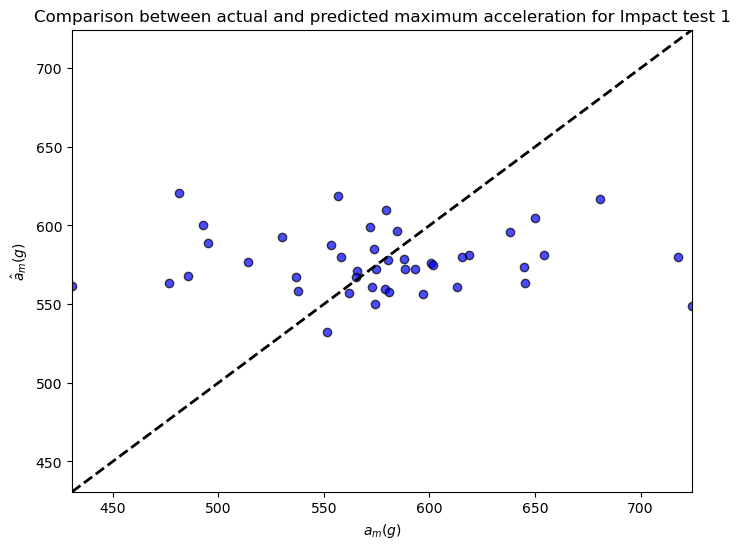

In [296]:
fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(ytrue,ypred,color='blue', alpha=0.7, edgecolor='k', label='Predicted vs Actual')
ax.plot([min(ytrue)[0],max(ytrue)[0]],[min(ytrue)[0],max(ytrue)[0]],color='black', linestyle='--', linewidth=2, label='Ideal Fit')
min_val = min(min(ytrue), min(ypred))
max_val = max(max(ytrue), max(ypred))

ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])

ax.set_xlabel('$a_m(g)$')
ax.set_ylabel('$\hat{a}_m(g)$')
ax.set_title('Comparison between actual and predicted maximum acceleration for Impact test 1')

In [228]:
predict_acc1=Acc3.predict(Xtest_tr_poly).reshape(-1,1)
predict_acc1=Y.inverse_transform(predict_acc1)
acc1_r2=r2_score(Ytest,predict_acc1)
acc1_msq=mean_squared_error(Ytest,predict_acc1)

Text(0.5, 1.0, 'Comparison between actual and predicted maximum accelration for Impact test 2')

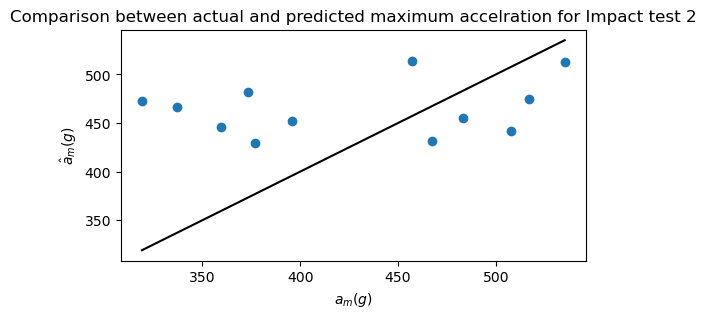

In [229]:
fig,ax=plt.subplots(figsize=(6,3))

ax.scatter(Ytest,predict_acc1)
ax.plot([Ytest.min(),Ytest.max()],[Ytest.min(),Ytest.max()],color='black')
ax.set_xlabel('$a_m(g)$')
ax.set_ylabel('$\hat{a}_m(g)$')
ax.set_title('Comparison between actual and predicted maximum accelration for Impact test 2')

In [230]:
print(acc1_r2)
print(np.sqrt(acc1_msq))

-0.23759888028227505
80.44454435466996
